# Datamodeller för sifferigenkänning - MNIST Dataset

Följande modeller kommer att användas för att känna igen siffror från MNIST-datasetet:

- **SVM LinearSVC**
- **Random Forest**
- **KNN**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import cv2

from sklearn.datasets import fetch_openml
from scipy.stats import uniform, randint
from scipy.ndimage import center_of_mass
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, classification_report
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
# Laddar MNIST-datasetet
mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)

X = mnist["data"]
y = mnist["target"].astype(np.uint8)

In [3]:
print(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

Delar upp datan i träningsdata, valideringsdata och testdata

In [3]:
def load_and_preprocess_data():
    # Dela upp data i träning och test först
    X_train_all, X_test, y_train_all, y_test = train_test_split(
        X, y, test_size=0.1, random_state=42
    )

    # Dela upp träningsdatan i två delar: träning och validering
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_all, y_train_all, test_size=0.2, random_state=42
    )

    return X_train, X_val, X_test, y_train, y_val, y_test
X_train, X_val, X_test, y_train, y_val, y_test = load_and_preprocess_data()

In [4]:
#Normaliserar
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

EDA

In [6]:
#Konverterar bilderna till dataframe
train_df = pd.DataFrame(X_train) 
train_df['label'] = y_train 

In [7]:
#Kontroll av saknade värden
print("\n Antal saknade värden i datasetet:", train_df.isnull().sum().sum())


 Antal saknade värden i datasetet: 0


In [8]:
#Grundläggande statistik över pixelvärden
print(train_df.describe())

             0        1        2        3        4        5        6        7  \
count  50400.0  50400.0  50400.0  50400.0  50400.0  50400.0  50400.0  50400.0   
mean       0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
std        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
min        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
25%        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
50%        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
75%        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
max        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

             8        9  ...           775           776           777  \
count  50400.0  50400.0  ...  50400.000000  50400.000000  50400.000000   
mean       0.0      0.0  ...      0.000389      0.000175      0.000064   
std        0.0      0.0  ...      0.017013      

In [9]:
# Räknar antalet bilder per siffra
image_count = train_df['label'].value_counts().reset_index()
image_count.columns = ['Siffra', 'Antal bilder']
image_count = image_count.sort_values('Siffra')

# Skriver ut antalet bilder per siffra i en tabell
print(image_count.to_markdown(index=False))

|   Siffra |   Antal bilder |
|---------:|---------------:|
|        0 |           4967 |
|        1 |           5636 |
|        2 |           5089 |
|        3 |           5124 |
|        4 |           4962 |
|        5 |           4479 |
|        6 |           5042 |
|        7 |           5234 |
|        8 |           4838 |
|        9 |           5029 |


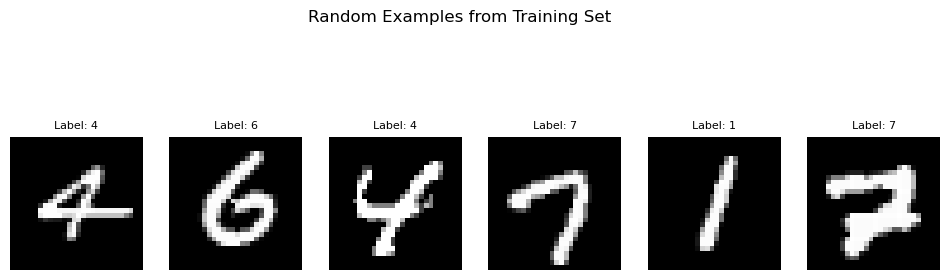

In [10]:
# Visualisera några exempelbilder
fig, axes = plt.subplots(1, 6, figsize=(12, 4))
axes = axes.ravel()

for i in np.arange(6):
    index = np.random.randint(0, len(train_df))
    axes[i].imshow(train_df.drop('label', axis=1).iloc[index].values.reshape(28, 28), cmap='gray')
    axes[i].set_title(f"Label: {train_df['label'].iloc[index]}", fontsize=8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.5)
plt.suptitle("Random Examples from Training Set", fontsize=12)
plt.show()

Tränar modeller

In [11]:
# Definiera pipelines för varje modell
print("Definierar pipelines för varje modell...")

# SVM LinearSVC
pipeline_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', LinearSVC(random_state=42, C=0.05, loss='hinge', tol=1e-3, max_iter=4000, dual="auto"))
])

# Random Forest
pipeline_rf = Pipeline([
('rf', RandomForestClassifier(random_state=42, n_estimators=120, max_depth=10, min_samples_split=20, min_samples_leaf=10, criterion='gini', max_features=0.5))
])

# KNN
pipeline_knn = Pipeline([
('scaler', StandardScaler()),
('knn', KNeighborsClassifier(n_neighbors=8, weights='uniform', algorithm='auto'))
])

#Funktion för träning och evaluering av modeller
def train_and_evaluate(model, X_train, y_train, X_val, y_val):
    model_name = model.steps[-1][1].__class__.__name__
    print(f"Tränar modellen: {model_name}...")
    model.fit(X_train, y_train)  

    # Gör förutsägelser på träningsdata
    print(f"Gör förutsägelser på träningsdata...")
    y_pred_train = model.predict(X_train)

    # Gör förutsägelser på valideringsdata
    print(f"Gör förutsägelser på valideringsdata...")
    y_pred_val = model.predict(X_val)

    # Beräkna noggrannhet för tränings- och valideringsdata
    print(f"Beräknar noggrannhet...")
    accuracy_train = accuracy_score(y_train, y_pred_train)
    accuracy_val = accuracy_score(y_val, y_pred_val)

    print(f"Noggrannhet på träningsdata: {accuracy_train:.4f}")
    print(f"Noggrannhet på valideringsdata: {accuracy_val:.4f}")

    return model, accuracy_train, accuracy_val

# Utvärdering av modellerna
print("Träning och utvärdering av LinearSVC:")
svm_model, svm_train_accuracy, svm_val_accuracy = train_and_evaluate(pipeline_svm, X_train, y_train, X_val, y_val)

print("\nTräning och utvärdering av RandomForestClassifier:")
rf_model, rf_train_accuracy, rf_val_accuracy = train_and_evaluate(pipeline_rf, X_train, y_train, X_val, y_val)

print("\nTräning och utvärdering av KNeighborsClassifier:")
knn_model, knn_train_accuracy, knn_val_accuracy = train_and_evaluate(pipeline_knn, X_train, y_train, X_val, y_val)

# Väljer den bästa modellen baserat på valideringsnoggrannhet
best_model = None
best_accuracy = 0

if svm_val_accuracy > best_accuracy:
    best_accuracy = svm_val_accuracy
    best_model = svm_model

if rf_val_accuracy > best_accuracy:
    best_accuracy = rf_val_accuracy
    best_model = rf_model

if knn_val_accuracy > best_accuracy:
    best_accuracy = knn_val_accuracy
    best_model = knn_model

print(f"\nBästa modellen baserat på valideringsnoggrannhet: {best_model.steps[-1][1].__class__.__name__} med noggrannhet {best_accuracy:.4f}")

# Sparar den bästa modellen
model_filename = "best_model.pkl"
joblib.dump(best_model, model_filename)

# Korrekt utskrift av den bästa modellen
print(f"Den bästa modellen ({best_model.steps[-1][1].__class__.__name__}) har sparats som {model_filename}")

Definierar pipelines för varje modell...
Träning och utvärdering av LinearSVC:
Tränar modellen: LinearSVC...


c:\Users\CD\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Gör förutsägelser på träningsdata...
Gör förutsägelser på valideringsdata...
Beräknar noggrannhet...
Noggrannhet på träningsdata: 0.9288
Noggrannhet på valideringsdata: 0.9158

Träning och utvärdering av RandomForestClassifier:
Tränar modellen: RandomForestClassifier...
Gör förutsägelser på träningsdata...
Gör förutsägelser på valideringsdata...
Beräknar noggrannhet...
Noggrannhet på träningsdata: 0.9621
Noggrannhet på valideringsdata: 0.9449

Träning och utvärdering av KNeighborsClassifier:
Tränar modellen: KNeighborsClassifier...
Gör förutsägelser på träningsdata...
Gör förutsägelser på valideringsdata...
Beräknar noggrannhet...
Noggrannhet på träningsdata: 0.9534
Noggrannhet på valideringsdata: 0.9434

Bästa modellen baserat på valideringsnoggrannhet: RandomForestClassifier med noggrannhet 0.9449
Den bästa modellen (RandomForestClassifier) har sparats som best_model.pkl


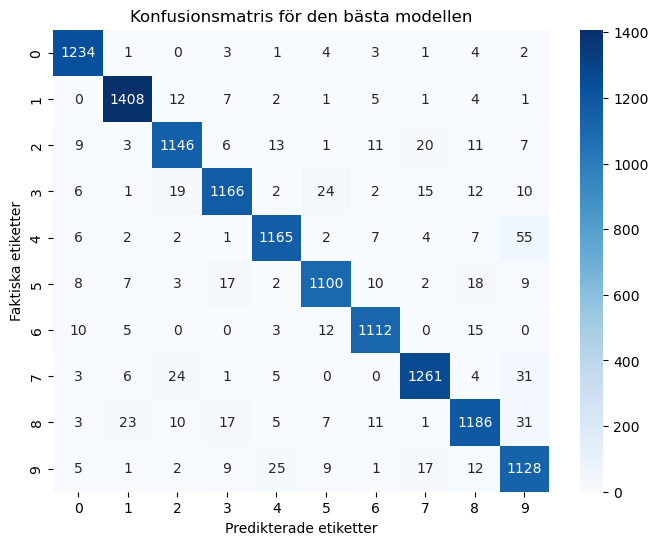

In [9]:
# Ladda den bästa modellen
best_model = joblib.load("best_model.pkl")

# Gör förutsägelser på valideringsdatan
y_pred_best = best_model.predict(X_val)

# Skapa konfusionsmatris
cm = confusion_matrix(y_val, y_pred_best)

# Visa konfusionsmatrisen
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=set(y_val), yticklabels=set(y_val))
plt.xlabel("Predikterade etiketter")
plt.ylabel("Faktiska etiketter")
plt.title("Konfusionsmatris för den bästa modellen")
plt.show()

Vald testmängd: 50 bilder
Börjar centrera bilder med avancerad metod...
Centrerar bild 0 av 50
Centrering slutförd!


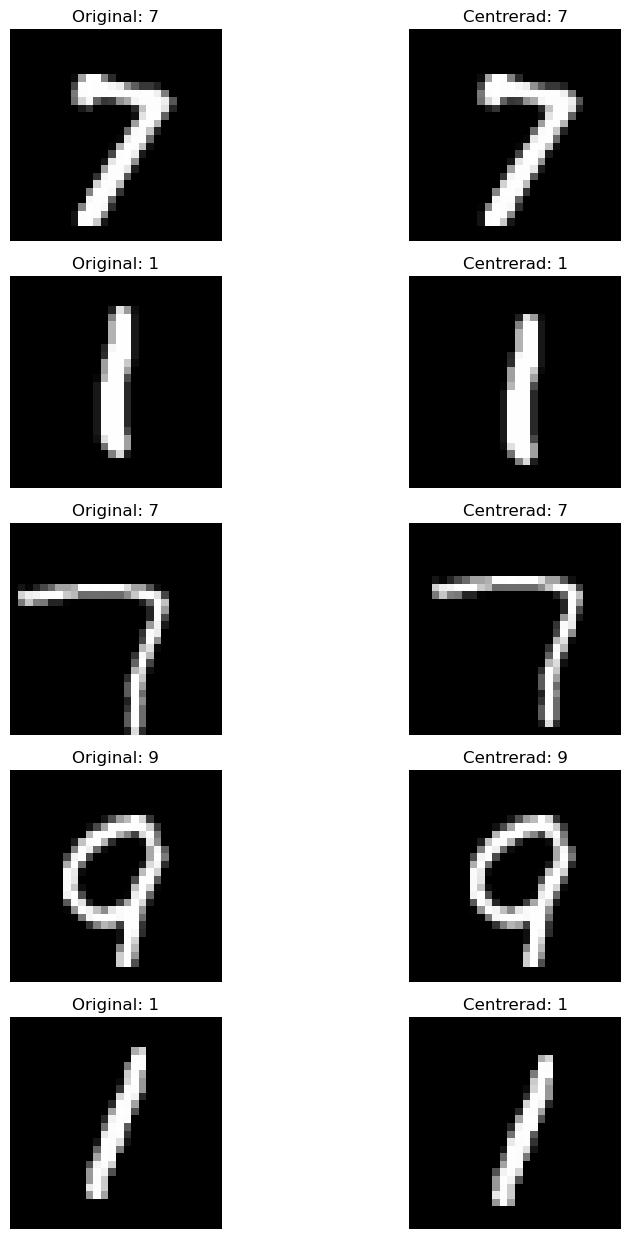

In [ ]:
# Centerering av bilderna för att hantera asymmetriska siffror

def center_mnist_image_advanced(image):
   
    if image.max() <= 1.0:
        img = (image * 255).reshape(28, 28).astype(np.uint8)
    else:
        img = image.reshape(28, 28).astype(np.uint8)
    
    # Hitta bounding box (icke-noll pixlar)
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    
    if not np.any(rows) or not np.any(cols):
        return image  # Tomt, returnera originalet
    
    # Hitta yttre gränser
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    
    # Beräkna center av bounding box
    rcenter = (rmin + rmax) // 2
    ccenter = (cmin + cmax) // 2
    
    # Beräkna center of mass
    cy, cx = center_of_mass(img)
    
    # Detektera potentiella sjuor och liknande asymmetriska siffror
    is_likely_seven = False
    
    # Check om siffran är högre än bred och har tyngd i övre delen
    if (rmax - rmin) > (cmax - cmin):
        # Dela bilden i övre och nedre halva
        upper_half = img[rmin:rmin+(rmax-rmin)//2, :]
        lower_half = img[rmin+(rmax-rmin)//2:rmax+1, :]
        
        # Om övre halvan har mer pixlar och är koncentrerad till höger
        if upper_half.sum() > lower_half.sum() * 0.8:
            upper_left = upper_half[:, :ccenter].sum()
            upper_right = upper_half[:, ccenter:].sum()
            
            if upper_right > upper_left * 1.5:
                is_likely_seven = True
    
    # Viktad centrering baserad på siffertyp
    if is_likely_seven:
        # För sjuor, lägg mer vikt vid bounding box center (60%) 
        # än på center of mass (40%)
        final_cy = int(0.6 * rcenter + 0.4 * cy)
        final_cx = int(0.6 * ccenter + 0.4 * cx)
    else:
        # För andra siffror, använd 40% boundingbox och 60% center of mass
        final_cy = int(0.4 * rcenter + 0.6 * cy)
        final_cx = int(0.4 * ccenter + 0.6 * cx)
    
    # Beräkna förskjutning
    shift_y = 14 - final_cy
    shift_x = 14 - final_cx
    
    # Skapa transformationsmatris
    M = np.float32([[1, 0, shift_x], [0, 1, shift_y]])
    
    # Utför translationen
    centered_img = cv2.warpAffine(img, M, (28, 28), borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    
    # Returnera med samma normalisering
    if image.max() <= 1.0:
        return (centered_img / 255.0).reshape(784)
    else:
        return centered_img.reshape(784)

def center_mnist_dataset(X):
    """Centrera dataset med avancerad metod"""
    print("Börjar centrera bilder med avancerad metod...")
    centered_X = np.zeros_like(X)
    for i in range(len(X)):
        if i % 1000 == 0:  # Visa framsteg var 1000:e bild
            print(f"Centrerar bild {i} av {len(X)}")
        centered_X[i] = center_mnist_image_advanced(X[i])
    print("Centrering slutförd!")
    return centered_X

def visualize_centering_comparison(original_X, centered_X, y, num_examples=5):
    """Jämför och visualiserar original och avancerad centrering"""
    plt.figure(figsize=(10, 2.5 * num_examples))
    
    # Försök inkludera en sjua om möjligt
    indices = []
    
    # Först leta efter en sjua
    seven_indices = np.where(y == 7)[0]
    if len(seven_indices) > 0:
        indices.append(seven_indices[0])
    
    # Fyll på med slumpmässiga siffror
    remaining = num_examples - len(indices)
    if remaining > 0:
        rand_indices = np.random.randint(0, len(original_X), size=remaining)
        indices.extend(rand_indices)
    
    for i, idx in enumerate(indices):
        # Visa originalbild
        plt.subplot(num_examples, 2, i*2+1)
        plt.imshow(original_X[idx].reshape(28, 28), cmap='gray')
        plt.title(f"Original: {y[idx]}")
        plt.axis('off')
        
        # Visa centrerad bild
        plt.subplot(num_examples, 2, i*2+2)
        plt.imshow(centered_X[idx].reshape(28, 28), cmap='gray')
        plt.title(f"Centrerad: {y[idx]}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('centering_comparison.png')
    plt.show()

# Test av centrering på en delmängd
test_size = 50
test_X = X_train[:test_size]
test_y = y_train[:test_size]
print(f"Vald testmängd: {test_size} bilder")

test_X_centered = center_mnist_dataset(test_X)

# Visualisera jämförelsen
visualize_centering_comparison(test_X, test_X_centered, test_y, num_examples=5)

In [20]:
# Centrera träningsdatan
print("Centrerar träningsdata...")
X_train_centered = center_mnist_dataset(X_train)

# Centrera valideringsdatan
print("Centrerar valideringsdata...")
X_val_centered = center_mnist_dataset(X_val)

# Centrera testdatan
print("Centrerar testdata...")
X_test_centered = center_mnist_dataset(X_test)

# Kombinera tränings- och valideringsdata för slutlig träning
X_combined = np.vstack((X_train_centered, X_val_centered))
y_combined = np.concatenate((y_train, y_val))

# Sparar de centrerade dataseten
print("Sparar centrerade dataset...")
np.save('X_train_centered.npy', X_train_centered)
np.save('X_val_centered.npy', X_val_centered)
np.save('X_test_centered.npy', X_test_centered)
np.save('X_combined.npy', X_combined)
np.save('y_combined.npy', y_combined)
print("Centrering och kombination av data slutförd!")

Centrerar träningsdata...
Börjar centrera bilder med avancerad metod...
Centrerar bild 0 av 50400
Centrerar bild 1000 av 50400
Centrerar bild 2000 av 50400
Centrerar bild 3000 av 50400
Centrerar bild 4000 av 50400
Centrerar bild 5000 av 50400
Centrerar bild 6000 av 50400
Centrerar bild 7000 av 50400
Centrerar bild 8000 av 50400
Centrerar bild 9000 av 50400
Centrerar bild 10000 av 50400
Centrerar bild 11000 av 50400
Centrerar bild 12000 av 50400
Centrerar bild 13000 av 50400
Centrerar bild 14000 av 50400
Centrerar bild 15000 av 50400
Centrerar bild 16000 av 50400
Centrerar bild 17000 av 50400
Centrerar bild 18000 av 50400
Centrerar bild 19000 av 50400
Centrerar bild 20000 av 50400
Centrerar bild 21000 av 50400
Centrerar bild 22000 av 50400
Centrerar bild 23000 av 50400
Centrerar bild 24000 av 50400
Centrerar bild 25000 av 50400
Centrerar bild 26000 av 50400
Centrerar bild 27000 av 50400
Centrerar bild 28000 av 50400
Centrerar bild 29000 av 50400
Centrerar bild 30000 av 50400
Centrerar b

In [21]:
# Laddar bästa modellen (Random Forest) och fortsätt träna på centrerade data
import joblib

print("Laddar bästa modellen från tidigare träning...")
final_model = joblib.load("best_model.pkl")  # Ladda tidigare sparad modell

# Träna på kombinerad data för slutlig modell
print("Tränar slutgiltig modell på kombinerad centrerad data...")
final_model.fit(X_combined, y_combined)

# Utvärdera modellen
print("Utvärderar modellen på centrerad testdata...")
test_accuracy = final_model.score(X_test_centered, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

# Spara modellen
print("Sparar slutgiltig modell...")
joblib.dump(final_model, "final_model_advanced_centered.pkl")
print("Modell sparad!")

Laddar bästa modellen från tidigare träning...
Tränar slutgiltig modell på kombinerad centrerad data...
Utvärderar modellen på centrerad testdata...
Test accuracy: 0.9357
Sparar slutgiltig modell...
Modell sparad!


Utvärderar modellen...
Noggrannhet på centrerad testdata: 0.9357

Klassificeringsrapport:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       683
           1       0.96      0.97      0.97       800
           2       0.93      0.93      0.93       674
           3       0.93      0.89      0.91       760
           4       0.92      0.94      0.93       611
           5       0.94      0.94      0.94       658
           6       0.96      0.97      0.97       677
           7       0.93      0.94      0.93       724
           8       0.91      0.88      0.90       693
           9       0.90      0.91      0.91       720

    accuracy                           0.94      7000
   macro avg       0.94      0.94      0.94      7000
weighted avg       0.94      0.94      0.94      7000



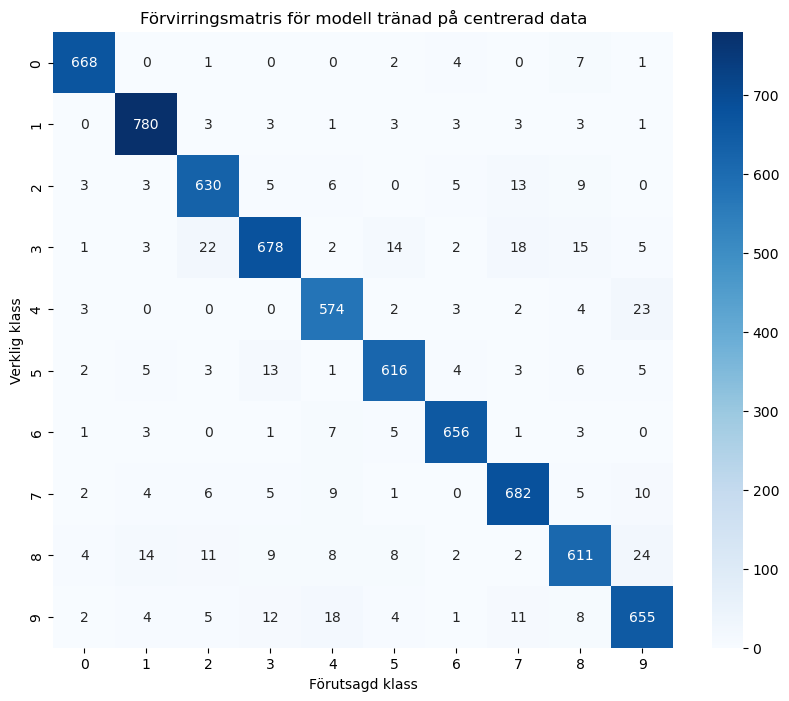

In [22]:
# Utvärdera på centrerad testdata
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("Utvärderar modellen...")
y_pred = final_model.predict(X_test_centered)
accuracy = accuracy_score(y_test, y_pred)
print(f"Noggrannhet på centrerad testdata: {accuracy:.4f}")

# Visa detaljerad rapport
print("\nKlassificeringsrapport:")
print(classification_report(y_test, y_pred))

# Skapa och visa förvirringsmatris
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Förutsagd klass')
plt.ylabel('Verklig klass')
plt.title('Förvirringsmatris för modell tränad på centrerad data')
plt.savefig('centered_confusion_matrix.png')
plt.show()

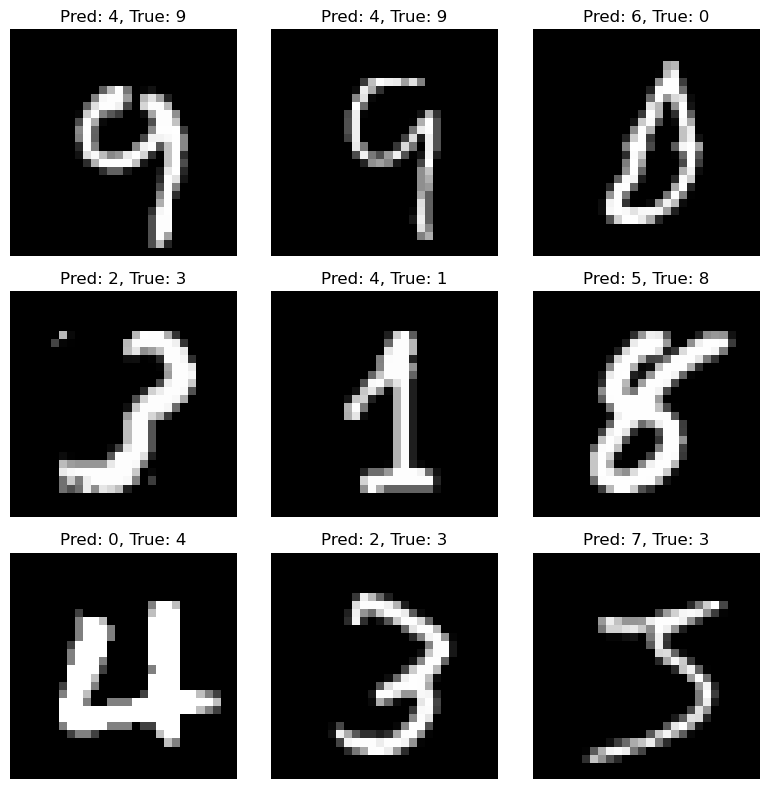

In [ ]:
# Testar att hitta fel på tränad och centrera data
misclassified_idx = np.where(y_pred != y_test)[0]

fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for ax, idx in zip(axes.flatten(), misclassified_idx[:9]):
    # Använd X_test_centered istället för X_test
    ax.imshow(X_test_centered[idx].reshape(28, 28), cmap='gray')
    ax.set_title(f"Pred: {y_pred[idx]}, True: {y_test[idx]}")
    ax.axis('off')

plt.tight_layout()
plt.show()